In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.autograd import Variable
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
import CancerDataset_global_pooled_multi_datasets_all
from sklearn.metrics import matthews_corrcoef
import DatasetTransform_global_pooled_all
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import KFold
import xgboost as xgb
from sklearn.svm import SVC
from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pickle
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import time
import os
import pandas as pd
from imblearn.over_sampling import SMOTE
dir_path = os.path.dirname(os.path.abspath(os.curdir))
#Input dataset
Tr_CancerProjects=["TCGA-BRCA","TCGA-KIRC","TCGA-KIRP","TCGA-LIHC","TCGA-LUAD","TCGA-LUSC","TCGA-PRAD","TCGA-THCA","TCGA-UCEC"] ###Training and fine-tuning datasets
Te_CancerProjects=["TCGA-BLCA","TCGA-CHOL","TCGA-COAD","TCGA-ESCA","TCGA-HNSC","TCGA-KICH","TCGA-READ","TCGA-STAD"] ###Testing datasets

In [2]:
class MyNetwork(nn.Module):
    def __init__(self):
        super(MyNetwork,self).__init__()
        self.ConvLayer1 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=(3,3), stride=1,padding=1),
            nn.Conv2d(6, 12, kernel_size=(3,3), stride=1,padding=1),
            #nn.MaxPool2d(2),
            nn.ReLU()
            )
        self.ConvLayer2 = nn.Sequential(
            nn.Conv2d(12, 24, kernel_size=(3,3), stride=1,padding=1),
            nn.Conv2d(24, 48, kernel_size=(3,3), stride=1,padding=1),
            #nn.MaxPool2d(2),
            nn.ReLU()
            )
        self.ConvLayer3 = nn.Sequential(
            nn.Conv2d(48, 64, kernel_size=(3,3), stride=1,padding=1),
            nn.Conv2d(64, 102, kernel_size=(3,3), stride=1,padding=1),
            #nn.MaxPool2d(2),
            nn.ReLU()
            )
        self.ConvLayer4 = nn.Sequential(
            nn.Conv2d(102, 164, kernel_size=(3,3), stride=1,padding=1),
            nn.Conv2d(164, 256, kernel_size=(3,3), stride=1,padding=1),
            nn.MaxPool2d(2),
            nn.ReLU()
            )
        self.global_pool = nn.AdaptiveMaxPool2d((1,1))
        self.Lin1 = nn.Sequential(
                nn.Linear(256,120),
                nn.ReLU()
            )
        self.Lin2 = nn.Sequential(
                nn.Linear(120,64),
                nn.ReLU()
            )
        self.Lin3 = nn.Sequential(
                nn.Linear(64,32),
                nn.ReLU()
                    )
        self.Lin4 = nn.Sequential(
                nn.Linear(32,8),
                nn.ReLU()
                    )
        self.Lin5 = nn.Sequential(
                nn.Linear(8,3),
                nn.ReLU()
                    )
        self.func=nn.Softmax(dim=1)
    def forward(self,x):
        x = self.ConvLayer1(x)
        x = self.ConvLayer2(x)
        x = self.ConvLayer3(x)
        x = self.ConvLayer4(x)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.Lin1(x)
        x = self.Lin2(x)
        x = self.Lin3(x)
        x = self.Lin4(x)
        x = self.Lin5(x)
        output = self.func(x)
        return output


def calculate_accuracy_from_cm(Y_t,y_hat_class):
    cm_accuracy=accuracy_score(Y_t, y_hat_class,normalize=True)
    cm_recall=recall_score(Y_t, y_hat_class, average='weighted')
    precision=precision_score(Y_t, y_hat_class, average='weighted')
    cm_f_measure=f1_score(Y_t, y_hat_class, average='weighted')
    cm_mcc=matthews_corrcoef(Y_t,y_hat_class)
    return cm_accuracy*100, cm_recall*100, precision*100, cm_f_measure,cm_mcc

def train(model,samples):
    training_accuracy = []
    training_recall = []
    training_precision = []
    training_fmeasure = []
    training_mcc=[]
    training_loss=[]
    y_true=[]
    y_scores=[]


    print("Training started....")
    model.train()
    #size=samples
    for img, y_img in train_loader:
        img = Variable(img)
        X_t = torch.FloatTensor(img)
        
        y_img = y_img.view(y_img.size(0), -1)
        y_img = Variable(y_img)
        if torch.cuda.is_available():
            X_t, y_img = X_t.cuda(), y_img.cuda()
        y_hat= model(X_t)
        id=torch.arange(0,y_hat.shape[0])
        varr=y_img.flatten().long()
        
        true_label = torch.zeros(y_hat.shape[0],3)
        true_label[id,varr]=1
        
        loss = loss_func(y_hat,varr)
        training_loss.append(loss.item())
        #print(loss.item())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        _,predicted=torch.max(y_hat,1)
        y_hat_class = predicted
        
        #if batch % 100 == 0:
            #loss, current = loss.item(), (batch + 1) * len(img)
            #print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        cm_accuracy, cm_recall, precision, f_measure,mcc=calculate_accuracy_from_cm(y_img.cpu().numpy(),y_hat_class.cpu().numpy())
        training_accuracy.append(cm_accuracy)
        training_recall.append(cm_recall)
        training_precision.append(precision)
        training_fmeasure.append(f_measure)
        training_loss.append(loss)
        training_mcc.append(mcc)

    return training_accuracy, training_recall,training_precision,training_fmeasure,training_mcc,training_loss

@torch.no_grad()
def valid(model,sets):
    val_accuracy = []
    val_recall = []
    val_precision = []
    val_fmeasure = []
    val_mcc=[]
    val_loss=[]


    print("Validation started....")
    for img, y_img in val_loader:
        img = Variable(img)
        X_t = torch.FloatTensor(img)
        
        y_img = y_img.view(y_img.size(0), -1)
        y_img = Variable(y_img)
        if torch.cuda.is_available():
            X_t, y_img = X_t.cuda(), y_img.cuda()
        y_hat= model(X_t)
        id=torch.arange(0,y_hat.shape[0])
        varr=y_img.flatten().long()
        
        
        
        true_label = torch.zeros(y_hat.shape[0],3)
        true_label[id,varr]=1
        
        loss = loss_func(y_hat,varr)
        
        val_loss.append(loss.item())
        
        _,predicted=torch.max(y_hat,1)
        y_hat_class = predicted
        cm_accuracy, cm_recall, precision, f_measure,mcc=calculate_accuracy_from_cm(y_img.cpu().numpy(),y_hat_class.cpu().numpy())
        val_accuracy.append(cm_accuracy)
        val_recall.append(cm_recall)
        val_precision.append(precision)
        val_fmeasure.append(f_measure)
        val_loss.append(loss)
        val_mcc.append(mcc)

    return val_accuracy, val_recall,val_precision,val_fmeasure,val_mcc,val_loss

@torch.no_grad()
def test(model,Project):
    test_loss = []
    test_accuracy = []
    test_recall = []
    test_precision = []
    test_fmeasure = []
    test_MCC=[]
    cum_accuracy=0
    cum_precision=0
    cum_MCC=0
    labels_predict=np.array([])
    prob_predict=np.array([])
    for data in test_loader:
        img, y_img = data
        img = Variable(img)
        y_img = y_img.view(y_img.size(0), -1)
        y_img = Variable(y_img)
        X_t = torch.FloatTensor(img)
        if torch.cuda.is_available():
            X_t, y_img = X_t.cuda(), y_img.cuda()
        
        y_hat= model(X_t)
        #Y_t = torch.from_numpy(y_img.cpu().numpy())
        #print(y_hat)
        #print(y_img)
        id=torch.arange(0,y_hat.shape[0])
        varr=y_img.flatten().long()
        
        
        
        true_label = torch.zeros(y_hat.shape[0],3)
        true_label[id,varr]=1
        #print(varr)
        loss = loss_func(y_hat,varr)

        test_loss.append(loss.item())
        
        '''y_hat =y_hat.cpu().detach().numpy()
        y_hat_class = np.where(y_hat<0.5, 0, 1)
        #print(y_hat)
        print(y_hat_class)
        labels_predict=np.append(labels_predict,y_hat_class)
        prob_predict=np.append(prob_predict,y_hat)
        y_img = y_img.cpu().detach()
        print(y_img)'''
        
        _,predicted=torch.max(y_hat,1)
        y_hat_class = predicted
        y_hat_class =y_hat_class.cpu().detach().numpy()
        y_hat = y_hat.cpu().detach().numpy()
        
        labels_predict=np.append(labels_predict,y_hat_class)
        prob_predict=np.append(prob_predict,y_hat)
        
        y_img = y_img.cpu().detach().numpy()
        
        mcc=matthews_corrcoef(y_hat_class,y_img)
        cm_accuracy, cm_recall, precision, fmeasure,mcc =calculate_accuracy_from_cm(y_img,y_hat_class)
        print(y_img)
        print(y_hat_class)
        print(cm_accuracy)
        test_accuracy.append(cm_accuracy)
        test_recall.append(cm_recall)
        test_precision.append(precision)
        test_fmeasure.append(fmeasure)
        test_MCC.append(mcc)
    File = 'Test_predicted_labels_'+str(Project)+'.txt'
    labels_predict=labels_predict.astype(np.int)
    np.savetxt(File, labels_predict,fmt='%i')
    File = 'Test_predicted_probs_'+str(Project)+'.txt'
    np.savetxt(File, prob_predict)
    cum_accuracy=sum(test_accuracy)/len(test_accuracy)
    cum_recall=sum(test_recall)/len(test_recall)
    cum_precision=sum(test_precision)/len(test_precision)
    cum_fmeasure=sum(test_fmeasure)/len(test_fmeasure)
    cum_MCC=sum(test_MCC)/len(test_MCC)
    return cum_accuracy, cum_recall,cum_precision,cum_fmeasure,cum_MCC

In [3]:
epoch=31
learning_rate=1e-4
np.random.seed(0)
torch.manual_seed(0)
loss_func = nn.CrossEntropyLoss()
performance_by_dataset=[]
auc_file=[]
model= MyNetwork()
if torch.cuda.is_available():
    model = model.cuda()

In [6]:
######################Training DEGnext model on T1 data of the training datasets ######################
C1_weights = []
L5_weights = []
for i in range(0,epoch):
    if(i>1):
        MyModelName='Model_TL.pth'
        model.load_state_dict(torch.load(MyModelName))
        model.eval()
        print('Model loaded...')
    for j in range(0,len(Tr_CancerProjects)):
        Project=Tr_CancerProjects[j]
        print("Training for ",Project," started....")
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False) #helped with fine tuning so lets see with initial
        train_dataset = CancerDataset_global_pooled_multi_datasets_all.MyDataset(data_type=Project,case='train',transform=DatasetTransform_global_pooled_all.Compose([DatasetTransform_global_pooled_all.ArrayToTensor()]))
        batch_size = 256
        train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
        samples=train_dataset.len
        training_accuracy,training_recall, training_precision,training_fmeasure,training_mcc,training_loss=train(model,samples)
        accuracy=sum(training_accuracy)/len(training_accuracy)
        recall=sum(training_recall)/len(training_recall)
        precision=sum(training_precision)/len(training_precision)
        fmeasure=sum(training_fmeasure)/len(training_fmeasure)
        mcc=sum(training_mcc)/len(training_mcc)
        loss = sum(training_loss)/len(training_loss)
        Train_results='Epoch '+str(i)+' Train results for '+Project+': accuracy: '+str(accuracy)+' recall: '+str(recall)+'  precision: '+str(precision)+' fmeasure: '+str(fmeasure)+' mcc: '+str(mcc)+' loss: '+str(loss)
        print(Train_results)
        performance_by_dataset=np.append(performance_by_dataset,Train_results)
        if i ==0 or i ==30:
            C1weights = model.state_dict()['ConvLayer1.0.weight']
            C1Weight_results='Epoch '+str(i)+' Weight results for first convolution layer '+Project+': '+str(C1weights)
            C1_weights = np.append(C1_weights, C1Weight_results)
            L5weights = model.state_dict()['Lin5.0.weight']
            L5Weight_results='Epoch '+str(i)+' Weight results for last linear layer '+Project+': '+str(L5weights)
            L5_weights = np.append(L5_weights, L5Weight_results)
        

    cum_accuracy=sum(training_accuracy)/len(training_accuracy)
    cum_recall=sum(training_recall)/len(training_recall)
    cum_precision=sum(training_precision)/len(training_precision)
    cum_fmeasure=sum(training_fmeasure)/len(training_fmeasure)
    cum_loss = sum(training_loss)/len(training_loss)
    cum_mcc=sum(training_mcc)/len(training_mcc)
    print("average training evaluation for all datasets for epoch ",str(i)," :",cum_loss, cum_accuracy, cum_recall,cum_precision,cum_fmeasure,cum_mcc)
    File='TL_Train_accuracy_selected_datasets_continued.txt'
    np.savetxt(File, performance_by_dataset, fmt='%s')
    File1='TL_Train_Conv1_Weights_selected_datasets_continued.txt'
    np.savetxt(File1, C1_weights, fmt='%s')
    File2='TL_Train_L5_Weights_selected_datasets_continued.txt'
    np.savetxt(File2, L5_weights, fmt='%s')
    MyModelName='Model_TL.pth'
    torch.save(model.state_dict(), MyModelName)



print("Training ended....")

Training for  TCGA-BRCA  started....
loading dataset
 single train dataset loading
Training started....


C:\Users\Jiang Loh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jiang Loh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jiang Loh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jiang Loh\AppDat

Epoch 0 Train results for TCGA-BRCA: accuracy: 35.455197704081634 recall: 35.455197704081634  precision: 27.426808529187724 fmeasure: 0.2687092056175354 mcc: -0.023377742172335823 loss: tensor(1.0973, device='cuda:0', grad_fn=<DivBackward0>)
Training for  TCGA-KIRC  started....
loading dataset
 single train dataset loading
Training started....


C:\Users\Jiang Loh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jiang Loh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jiang Loh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jiang Loh\AppDat

Epoch 0 Train results for TCGA-KIRC: accuracy: 48.43956452323277 recall: 48.43956452323277  precision: 36.9733272143943 fmeasure: 0.39404558038191234 mcc: 0.24630643908922717 loss: tensor(1.0550, device='cuda:0', grad_fn=<DivBackward0>)
Training for  TCGA-KIRP  started....
loading dataset
 single train dataset loading
Training started....


C:\Users\Jiang Loh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jiang Loh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jiang Loh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jiang Loh\AppDat

Epoch 0 Train results for TCGA-KIRP: accuracy: 35.49609375 recall: 35.49609375  precision: 21.522089472380713 fmeasure: 0.23601878111211355 mcc: 0.21782692531979606 loss: tensor(1.0830, device='cuda:0', grad_fn=<DivBackward0>)
Training for  TCGA-LIHC  started....
loading dataset
 single train dataset loading
Training started....


C:\Users\Jiang Loh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jiang Loh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jiang Loh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jiang Loh\AppDat

Epoch 0 Train results for TCGA-LIHC: accuracy: 49.28063680959303 recall: 49.28063680959303  precision: 28.736576039921637 fmeasure: 0.3301914485519289 mcc: 0.05992470866528282 loss: tensor(1.0711, device='cuda:0', grad_fn=<DivBackward0>)
Training for  TCGA-LUAD  started....
loading dataset
 single train dataset loading
Training started....


C:\Users\Jiang Loh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jiang Loh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jiang Loh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jiang Loh\AppDat

Epoch 0 Train results for TCGA-LUAD: accuracy: 52.39830043859649 recall: 52.39830043859649  precision: 39.85672992067817 fmeasure: 0.3973962119521304 mcc: 0.3409753498043972 loss: tensor(1.0148, device='cuda:0', grad_fn=<DivBackward0>)
Training for  TCGA-LUSC  started....
loading dataset
 single train dataset loading
Training started....


C:\Users\Jiang Loh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jiang Loh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jiang Loh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jiang Loh\AppDat

Epoch 0 Train results for TCGA-LUSC: accuracy: 67.29462174940899 recall: 67.29462174940899  precision: 48.55269310712797 fmeasure: 0.5591001210989286 mcc: 0.5525928455323479 loss: tensor(0.8793, device='cuda:0', grad_fn=<DivBackward0>)
Training for  TCGA-PRAD  started....
loading dataset
 single train dataset loading
Training started....


C:\Users\Jiang Loh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jiang Loh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jiang Loh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jiang Loh\AppDat

Epoch 0 Train results for TCGA-PRAD: accuracy: 46.17714802554488 recall: 46.17714802554488  precision: 27.141559916421677 fmeasure: 0.3220135246333351 mcc: 0.3976162149586716 loss: tensor(1.0369, device='cuda:0', grad_fn=<DivBackward0>)
Training for  TCGA-THCA  started....
loading dataset
 single train dataset loading
Training started....


C:\Users\Jiang Loh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jiang Loh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jiang Loh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jiang Loh\AppDat

Epoch 0 Train results for TCGA-THCA: accuracy: 50.67125905068383 recall: 50.67125905068383  precision: 49.33960008654869 fmeasure: 0.4263336325710144 mcc: 0.31211935532414686 loss: tensor(1.0190, device='cuda:0', grad_fn=<DivBackward0>)
Training for  TCGA-UCEC  started....
loading dataset
 single train dataset loading
Training started....


C:\Users\Jiang Loh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jiang Loh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jiang Loh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jiang Loh\AppDat

Epoch 0 Train results for TCGA-UCEC: accuracy: 34.65856481481481 recall: 34.65856481481481  precision: 24.253279833034142 fmeasure: 0.22581851385396667 mcc: 0.16099066585511979 loss: tensor(1.0868, device='cuda:0', grad_fn=<DivBackward0>)
average training evaluation for all datasets for epoch  0  : tensor(1.0868, device='cuda:0', grad_fn=<DivBackward0>) 34.65856481481481 34.65856481481481 24.253279833034142 0.22581851385396667 0.16099066585511979
Training for  TCGA-BRCA  started....
loading dataset
 single train dataset loading
Training started....


C:\Users\Jiang Loh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jiang Loh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jiang Loh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jiang Loh\AppDat

Epoch 1 Train results for TCGA-BRCA: accuracy: 60.1296768707483 recall: 60.1296768707483  precision: 39.13701196289538 fmeasure: 0.46932091195378606 mcc: 0.5008771285387966 loss: tensor(0.9260, device='cuda:0', grad_fn=<DivBackward0>)
Training for  TCGA-KIRC  started....
loading dataset
 single train dataset loading
Training started....


C:\Users\Jiang Loh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jiang Loh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jiang Loh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jiang Loh\AppDat

Epoch 1 Train results for TCGA-KIRC: accuracy: 69.13959273838361 recall: 69.13959273838361  precision: 51.37029006687444 fmeasure: 0.5824959323732193 mcc: 0.5865947396350922 loss: tensor(0.8575, device='cuda:0', grad_fn=<DivBackward0>)
Training for  TCGA-KIRP  started....
loading dataset
 single train dataset loading
Training started....


C:\Users\Jiang Loh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jiang Loh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jiang Loh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jiang Loh\AppDat

Epoch 1 Train results for TCGA-KIRP: accuracy: 53.5078125 recall: 53.5078125  precision: 37.69372429846705 fmeasure: 0.4147467218827331 mcc: 0.4649192556159158 loss: tensor(0.9858, device='cuda:0', grad_fn=<DivBackward0>)
Training for  TCGA-LIHC  started....
loading dataset
 single train dataset loading
Training started....


C:\Users\Jiang Loh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jiang Loh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jiang Loh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jiang Loh\AppDat

Epoch 1 Train results for TCGA-LIHC: accuracy: 52.93877180232558 recall: 52.93877180232558  precision: 32.328052176146045 fmeasure: 0.3829930272178607 mcc: 0.24529184039760107 loss: tensor(1.0117, device='cuda:0', grad_fn=<DivBackward0>)
Training for  TCGA-LUAD  started....
loading dataset
 single train dataset loading
Training started....


C:\Users\Jiang Loh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jiang Loh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jiang Loh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jiang Loh\AppDat

Epoch 1 Train results for TCGA-LUAD: accuracy: 64.69791666666667 recall: 64.69791666666667  precision: 53.63847241390672 fmeasure: 0.5618823575266807 mcc: 0.5231668158982113 loss: tensor(0.8971, device='cuda:0', grad_fn=<DivBackward0>)
Training for  TCGA-LUSC  started....
loading dataset
 single train dataset loading
Training started....


C:\Users\Jiang Loh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jiang Loh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jiang Loh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jiang Loh\AppDat

Epoch 1 Train results for TCGA-LUSC: accuracy: 75.76462765957447 recall: 75.76462765957447  precision: 72.07809407560791 fmeasure: 0.7182193401371888 mcc: 0.6559766483438886 loss: tensor(0.7922, device='cuda:0', grad_fn=<DivBackward0>)
Training for  TCGA-PRAD  started....
loading dataset
 single train dataset loading
Training started....


C:\Users\Jiang Loh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jiang Loh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jiang Loh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jiang Loh\AppDat

Epoch 1 Train results for TCGA-PRAD: accuracy: 51.20748623154441 recall: 51.20748623154441  precision: 31.199308493419167 fmeasure: 0.37039797223665105 mcc: 0.4475171456053336 loss: tensor(0.9967, device='cuda:0', grad_fn=<DivBackward0>)
Training for  TCGA-THCA  started....
loading dataset
 single train dataset loading
Training started....


C:\Users\Jiang Loh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jiang Loh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1 Train results for TCGA-THCA: accuracy: 63.07855239340306 recall: 63.07855239340306  precision: 67.44352103326666 fmeasure: 0.577639170412782 mcc: 0.4764564359040659 loss: tensor(0.9238, device='cuda:0', grad_fn=<DivBackward0>)
Training for  TCGA-UCEC  started....
loading dataset
 single train dataset loading
Training started....


C:\Users\Jiang Loh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jiang Loh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jiang Loh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jiang Loh\AppDat

Epoch 1 Train results for TCGA-UCEC: accuracy: 45.32262731481481 recall: 45.32262731481481  precision: 25.647088662413683 fmeasure: 0.3215851056023893 mcc: 0.32458674270523336 loss: tensor(1.0388, device='cuda:0', grad_fn=<DivBackward0>)
average training evaluation for all datasets for epoch  1  : tensor(1.0388, device='cuda:0', grad_fn=<DivBackward0>) 45.32262731481481 45.32262731481481 25.647088662413683 0.3215851056023893 0.32458674270523336
Model loaded...
Training for  TCGA-BRCA  started....
loading dataset
 single train dataset loading
Training started....
Epoch 2 Train results for TCGA-BRCA: accuracy: 77.55102040816327 recall: 77.55102040816327  precision: 81.45074069495867 fmeasure: 0.7714762453210877 mcc: 0.6760353832545383 loss: tensor(0.7801, device='cuda:0', grad_fn=<DivBackward0>)
Training for  TCGA-KIRC  started....
loading dataset
 single train dataset loading
Training started....


C:\Users\Jiang Loh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jiang Loh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jiang Loh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jiang Loh\AppDat

Epoch 2 Train results for TCGA-KIRC: accuracy: 69.76806801915878 recall: 69.76806801915878  precision: 52.988479348271575 fmeasure: 0.5947468111079592 mcc: 0.5954972009633165 loss: tensor(0.8439, device='cuda:0', grad_fn=<DivBackward0>)
Training for  TCGA-KIRP  started....
loading dataset
 single train dataset loading
Training started....


C:\Users\Jiang Loh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jiang Loh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jiang Loh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jiang Loh\AppDat

Epoch 2 Train results for TCGA-KIRP: accuracy: 63.39453125 recall: 63.39453125  precision: 58.575410310179095 fmeasure: 0.5640414136518797 mcc: 0.541138403749737 loss: tensor(0.9072, device='cuda:0', grad_fn=<DivBackward0>)
Training for  TCGA-LIHC  started....
loading dataset
 single train dataset loading
Training started....


C:\Users\Jiang Loh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jiang Loh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jiang Loh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jiang Loh\AppDat

Epoch 2 Train results for TCGA-LIHC: accuracy: 54.962867914244185 recall: 54.962867914244185  precision: 32.73075397503535 fmeasure: 0.4036544046762046 mcc: 0.3100161351550164 loss: tensor(0.9713, device='cuda:0', grad_fn=<DivBackward0>)
Training for  TCGA-LUAD  started....
loading dataset
 single train dataset loading
Training started....
Epoch 2 Train results for TCGA-LUAD: accuracy: 77.99150219298247 recall: 77.99150219298247  precision: 79.76815644074938 fmeasure: 0.7677081128843242 mcc: 0.6697144966096333 loss: tensor(0.7726, device='cuda:0', grad_fn=<DivBackward0>)
Training for  TCGA-LUSC  started....
loading dataset
 single train dataset loading
Training started....
Epoch 2 Train results for TCGA-LUSC: accuracy: 76.74950132978724 recall: 76.74950132978724  precision: 78.55467858201224 fmeasure: 0.7603215700603418 mcc: 0.6592015100352155 loss: tensor(0.7812, device='cuda:0', grad_fn=<DivBackward0>)
Training for  TCGA-PRAD  started....
loading dataset
 single train dataset loading

C:\Users\Jiang Loh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jiang Loh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jiang Loh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jiang Loh\AppDat

Epoch 2 Train results for TCGA-UCEC: accuracy: 48.997395833333336 recall: 48.997395833333336  precision: 27.013101415882513 fmeasure: 0.3459494337923001 mcc: 0.3881012897908194 loss: tensor(1.0078, device='cuda:0', grad_fn=<DivBackward0>)
average training evaluation for all datasets for epoch  2  : tensor(1.0078, device='cuda:0', grad_fn=<DivBackward0>) 48.997395833333336 48.997395833333336 27.013101415882513 0.3459494337923001 0.3881012897908194
Model loaded...
Training for  TCGA-BRCA  started....
loading dataset
 single train dataset loading
Training started....
Epoch 3 Train results for TCGA-BRCA: accuracy: 82.13222789115646 recall: 82.13222789115646  precision: 84.03253720760942 fmeasure: 0.8190280118714307 mcc: 0.7359151645394285 loss: tensor(0.7277, device='cuda:0', grad_fn=<DivBackward0>)
Training for  TCGA-KIRC  started....
loading dataset
 single train dataset loading
Training started....


C:\Users\Jiang Loh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jiang Loh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jiang Loh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jiang Loh\AppDat

Epoch 3 Train results for TCGA-KIRC: accuracy: 70.81366301475445 recall: 70.81366301475445  precision: 54.09097463518964 fmeasure: 0.6058075072583268 mcc: 0.6073928877679071 loss: tensor(0.8375, device='cuda:0', grad_fn=<DivBackward0>)
Training for  TCGA-KIRP  started....
loading dataset
 single train dataset loading
Training started....


C:\Users\Jiang Loh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jiang Loh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jiang Loh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jiang Loh\AppDat

Epoch 3 Train results for TCGA-KIRP: accuracy: 65.546875 recall: 65.546875  precision: 62.518028718367376 fmeasure: 0.5934003377225323 mcc: 0.5562903715222003 loss: tensor(0.8867, device='cuda:0', grad_fn=<DivBackward0>)
Training for  TCGA-LIHC  started....
loading dataset
 single train dataset loading
Training started....


C:\Users\Jiang Loh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jiang Loh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jiang Loh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jiang Loh\AppDat

Epoch 3 Train results for TCGA-LIHC: accuracy: 56.07569494912791 recall: 56.07569494912791  precision: 33.27606727504718 fmeasure: 0.41507969693758157 mcc: 0.3490265958903093 loss: tensor(0.9519, device='cuda:0', grad_fn=<DivBackward0>)
Training for  TCGA-LUAD  started....
loading dataset
 single train dataset loading
Training started....
Epoch 3 Train results for TCGA-LUAD: accuracy: 81.19270833333333 recall: 81.19270833333333  precision: 82.40062389581274 fmeasure: 0.806895451878123 mcc: 0.7110138651691815 loss: tensor(0.7382, device='cuda:0', grad_fn=<DivBackward0>)
Training for  TCGA-LUSC  started....
loading dataset
 single train dataset loading
Training started....
Epoch 3 Train results for TCGA-LUSC: accuracy: 78.78573803191489 recall: 78.78573803191489  precision: 81.6541297008186 fmeasure: 0.7853631118734005 mcc: 0.6863322339831952 loss: tensor(0.7612, device='cuda:0', grad_fn=<DivBackward0>)
Training for  TCGA-PRAD  started....
loading dataset
 single train dataset loading
Tr

C:\Users\Jiang Loh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jiang Loh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 3 Train results for TCGA-UCEC: accuracy: 60.332754629629626 recall: 60.332754629629626  precision: 60.896946684652576 fmeasure: 0.5710835358927673 mcc: 0.4065539413884675 loss: tensor(0.9563, device='cuda:0', grad_fn=<DivBackward0>)
average training evaluation for all datasets for epoch  3  : tensor(0.9563, device='cuda:0', grad_fn=<DivBackward0>) 60.332754629629626 60.332754629629626 60.896946684652576 0.5710835358927673 0.4065539413884675
Model loaded...
Training for  TCGA-BRCA  started....
loading dataset
 single train dataset loading
Training started....
Epoch 4 Train results for TCGA-BRCA: accuracy: 78.19807610544217 recall: 78.19807610544217  precision: 83.80692306507672 fmeasure: 0.7703310095877406 mcc: 0.6942743613353904 loss: tensor(0.7652, device='cuda:0', grad_fn=<DivBackward0>)
Training for  TCGA-KIRC  started....
loading dataset
 single train dataset loading
Training started....
Epoch 4 Train results for TCGA-KIRC: accuracy: 79.69515594032151 recall: 79.6951559403215

Training started....
Epoch 6 Train results for TCGA-LUAD: accuracy: 73.29084429824562 recall: 73.29084429824562  precision: 79.23971368982384 fmeasure: 0.722474629696418 mcc: 0.6165718037105492 loss: tensor(0.8161, device='cuda:0', grad_fn=<DivBackward0>)
Training for  TCGA-LUSC  started....
loading dataset
 single train dataset loading
Training started....
Epoch 6 Train results for TCGA-LUSC: accuracy: 70.65141105200945 recall: 70.65141105200945  precision: 72.06126943296738 fmeasure: 0.6814013657015564 mcc: 0.5678839661972542 loss: tensor(0.8439, device='cuda:0', grad_fn=<DivBackward0>)
Training for  TCGA-PRAD  started....
loading dataset
 single train dataset loading
Training started....
Epoch 6 Train results for TCGA-PRAD: accuracy: 78.10028269275838 recall: 78.10028269275838  precision: 80.07553551736375 fmeasure: 0.776556440767431 mcc: 0.658026302774239 loss: tensor(0.7685, device='cuda:0', grad_fn=<DivBackward0>)
Training for  TCGA-THCA  started....
loading dataset
 single train

Training started....
Epoch 9 Train results for TCGA-BRCA: accuracy: 82.09901147959184 recall: 82.09901147959184  precision: 85.14922966152474 fmeasure: 0.8209400858073816 mcc: 0.7384829925371135 loss: tensor(0.7305, device='cuda:0', grad_fn=<DivBackward0>)
Training for  TCGA-KIRC  started....
loading dataset
 single train dataset loading
Training started....
Epoch 9 Train results for TCGA-KIRC: accuracy: 78.59364677383836 recall: 78.59364677383836  precision: 80.99236014747095 fmeasure: 0.7823161513767984 mcc: 0.6875356908350607 loss: tensor(0.7645, device='cuda:0', grad_fn=<DivBackward0>)
Training for  TCGA-KIRP  started....
loading dataset
 single train dataset loading
Training started....
Epoch 9 Train results for TCGA-KIRP: accuracy: 76.72265625 recall: 76.72265625  precision: 79.42535413678021 fmeasure: 0.7614061741329985 mcc: 0.6417440355016543 loss: tensor(0.7831, device='cuda:0', grad_fn=<DivBackward0>)
Training for  TCGA-LIHC  started....
loading dataset
 single train dataset 

Training started....
Epoch 11 Train results for TCGA-LUSC: accuracy: 73.41164302600473 recall: 73.41164302600473  precision: 74.97240447811814 fmeasure: 0.7152316409746038 mcc: 0.6136624186262893 loss: tensor(0.8169, device='cuda:0', grad_fn=<DivBackward0>)
Training for  TCGA-PRAD  started....
loading dataset
 single train dataset loading
Training started....
Epoch 11 Train results for TCGA-PRAD: accuracy: 75.17430278884461 recall: 75.17430278884461  precision: 78.56722620252216 fmeasure: 0.7481703174096426 mcc: 0.6388969888543808 loss: tensor(0.7982, device='cuda:0', grad_fn=<DivBackward0>)
Training for  TCGA-THCA  started....
loading dataset
 single train dataset loading
Training started....
Epoch 11 Train results for TCGA-THCA: accuracy: 73.70336383748995 recall: 73.70336383748995  precision: 79.04581404827037 fmeasure: 0.7325589490433373 mcc: 0.5440570517143676 loss: tensor(0.8142, device='cuda:0', grad_fn=<DivBackward0>)
Training for  TCGA-UCEC  started....
loading dataset
 single

Training started....
Epoch 14 Train results for TCGA-KIRC: accuracy: 74.9282578176613 recall: 74.9282578176613  precision: 81.52022479119711 fmeasure: 0.7478981644577389 mcc: 0.6489825967718349 loss: tensor(0.8014, device='cuda:0', grad_fn=<DivBackward0>)
Training for  TCGA-KIRP  started....
loading dataset
 single train dataset loading
Training started....
Epoch 14 Train results for TCGA-KIRP: accuracy: 79.65625 recall: 79.65625  precision: 80.91022639865442 fmeasure: 0.794839008536796 mcc: 0.6827360612469506 loss: tensor(0.7548, device='cuda:0', grad_fn=<DivBackward0>)
Training for  TCGA-LIHC  started....
loading dataset
 single train dataset loading
Training started....
Epoch 14 Train results for TCGA-LIHC: accuracy: 77.72074854651163 recall: 77.72074854651163  precision: 78.57773658667152 fmeasure: 0.7735408429232539 mcc: 0.614357762531975 loss: tensor(0.7720, device='cuda:0', grad_fn=<DivBackward0>)
Training for  TCGA-LUAD  started....
loading dataset
 single train dataset loading

Training started....
Epoch 16 Train results for TCGA-PRAD: accuracy: 80.56029558237638 recall: 80.56029558237638  precision: 81.96328054398312 fmeasure: 0.8017442132278655 mcc: 0.6941076276622989 loss: tensor(0.7453, device='cuda:0', grad_fn=<DivBackward0>)
Training for  TCGA-THCA  started....
loading dataset
 single train dataset loading
Training started....
Epoch 16 Train results for TCGA-THCA: accuracy: 70.98093071198713 recall: 70.98093071198713  precision: 77.54399918224824 fmeasure: 0.71094580191409 mcc: 0.5358373657392549 loss: tensor(0.8415, device='cuda:0', grad_fn=<DivBackward0>)
Training for  TCGA-UCEC  started....
loading dataset
 single train dataset loading
Training started....
Epoch 16 Train results for TCGA-UCEC: accuracy: 78.3984375 recall: 78.3984375  precision: 80.09737581460544 fmeasure: 0.7802868568211376 mcc: 0.6648330477518315 loss: tensor(0.7650, device='cuda:0', grad_fn=<DivBackward0>)
average training evaluation for all datasets for epoch  16  : tensor(0.7650,

Training started....
Epoch 19 Train results for TCGA-KIRP: accuracy: 79.16796875 recall: 79.16796875  precision: 81.239720443755 fmeasure: 0.7899136035628579 mcc: 0.689555112314024 loss: tensor(0.7597, device='cuda:0', grad_fn=<DivBackward0>)
Training for  TCGA-LIHC  started....
loading dataset
 single train dataset loading
Training started....
Epoch 19 Train results for TCGA-LIHC: accuracy: 78.26978106831395 recall: 78.26978106831395  precision: 79.20801559944016 fmeasure: 0.7759679545753104 mcc: 0.6255752732037703 loss: tensor(0.7639, device='cuda:0', grad_fn=<DivBackward0>)
Training for  TCGA-LUAD  started....
loading dataset
 single train dataset loading
Training started....
Epoch 19 Train results for TCGA-LUAD: accuracy: 75.07072368421052 recall: 75.07072368421052  precision: 79.6199849974793 fmeasure: 0.7413940641442501 mcc: 0.6272988001558375 loss: tensor(0.7999, device='cuda:0', grad_fn=<DivBackward0>)
Training for  TCGA-LUSC  started....
loading dataset
 single train dataset l

Training started....
Epoch 21 Train results for TCGA-THCA: accuracy: 82.42973149637973 recall: 82.42973149637973  precision: 83.03108180916982 fmeasure: 0.8228260766476126 mcc: 0.6664533994041159 loss: tensor(0.7267, device='cuda:0', grad_fn=<DivBackward0>)
Training for  TCGA-UCEC  started....
loading dataset
 single train dataset loading
Training started....
Epoch 21 Train results for TCGA-UCEC: accuracy: 81.26302083333333 recall: 81.26302083333333  precision: 82.49778517391945 fmeasure: 0.8115868976410628 mcc: 0.713631895129727 loss: tensor(0.7360, device='cuda:0', grad_fn=<DivBackward0>)
average training evaluation for all datasets for epoch  21  : tensor(0.7360, device='cuda:0', grad_fn=<DivBackward0>) 81.26302083333333 81.26302083333333 82.49778517391945 0.8115868976410628 0.713631895129727
Model loaded...
Training for  TCGA-BRCA  started....
loading dataset
 single train dataset loading
Training started....
Epoch 22 Train results for TCGA-BRCA: accuracy: 75.46502976190477 recall:

Training started....
Epoch 24 Train results for TCGA-LIHC: accuracy: 77.21089207848837 recall: 77.21089207848837  precision: 78.83619375581264 fmeasure: 0.7671550803491749 mcc: 0.6133079885919658 loss: tensor(0.7698, device='cuda:0', grad_fn=<DivBackward0>)
Training for  TCGA-LUAD  started....
loading dataset
 single train dataset loading
Training started....
Epoch 24 Train results for TCGA-LUAD: accuracy: 84.19928728070175 recall: 84.19928728070175  precision: 85.90093949066996 fmeasure: 0.843673046639613 mcc: 0.7601036439437049 loss: tensor(0.7088, device='cuda:0', grad_fn=<DivBackward0>)
Training for  TCGA-LUSC  started....
loading dataset
 single train dataset loading
Training started....
Epoch 24 Train results for TCGA-LUSC: accuracy: 79.53697547281324 recall: 79.53697547281324  precision: 80.94399799878636 fmeasure: 0.7892258629667709 mcc: 0.6945563340856339 loss: tensor(0.7560, device='cuda:0', grad_fn=<DivBackward0>)
Training for  TCGA-PRAD  started....
loading dataset
 single 

Training started....
Epoch 26 Train results for TCGA-UCEC: accuracy: 80.50491898148148 recall: 80.50491898148148  precision: 82.46171095286661 fmeasure: 0.8026747088863384 mcc: 0.7000352607709791 loss: tensor(0.7414, device='cuda:0', grad_fn=<DivBackward0>)
average training evaluation for all datasets for epoch  26  : tensor(0.7414, device='cuda:0', grad_fn=<DivBackward0>) 80.50491898148148 80.50491898148148 82.46171095286661 0.8026747088863384 0.7000352607709791
Model loaded...
Training for  TCGA-BRCA  started....
loading dataset
 single train dataset loading
Training started....
Epoch 27 Train results for TCGA-BRCA: accuracy: 79.95588860544217 recall: 79.95588860544217  precision: 83.58935931482506 fmeasure: 0.7968494170113043 mcc: 0.7099048624202478 loss: tensor(0.7515, device='cuda:0', grad_fn=<DivBackward0>)
Training for  TCGA-KIRC  started....
loading dataset
 single train dataset loading
Training started....
Epoch 27 Train results for TCGA-KIRC: accuracy: 81.50866755670557 recal

Training started....
Epoch 29 Train results for TCGA-LUAD: accuracy: 83.84978070175438 recall: 83.84978070175438  precision: 85.02415678580327 fmeasure: 0.8355768812332205 mcc: 0.7539052769712031 loss: tensor(0.7126, device='cuda:0', grad_fn=<DivBackward0>)
Training for  TCGA-LUSC  started....
loading dataset
 single train dataset loading
Training started....
Epoch 29 Train results for TCGA-LUSC: accuracy: 83.39936096335697 recall: 83.39936096335697  precision: 85.90852271747016 fmeasure: 0.8356171614771392 mcc: 0.758040056317231 loss: tensor(0.7175, device='cuda:0', grad_fn=<DivBackward0>)
Training for  TCGA-PRAD  started....
loading dataset
 single train dataset loading
Training started....
Epoch 29 Train results for TCGA-PRAD: accuracy: 78.89672925943285 recall: 78.89672925943285  precision: 80.20556595733902 fmeasure: 0.7861721225419531 mcc: 0.6672273428862984 loss: tensor(0.7621, device='cuda:0', grad_fn=<DivBackward0>)
Training for  TCGA-THCA  started....
loading dataset
 single 

In [4]:
MyModelName='Model_TL.pth'
model.load_state_dict(torch.load(MyModelName))
model.state_dict()['ConvLayer1.0.weight']

tensor([[[[-0.0166,  0.1682, -0.2827],
          [-0.2559, -0.1336,  0.0854],
          [-0.0221,  0.2779, -0.0135]]],


        [[[ 0.0815, -0.1064, -0.0693],
          [-0.3230, -0.2165, -0.1433],
          [ 0.0062,  0.1385,  0.2001]]],


        [[[-0.2181, -0.1306,  0.1272],
          [ 0.2995, -0.0421,  0.2663],
          [-0.0347,  0.0619,  0.3312]]],


        [[[-0.3105, -0.2163, -0.0936],
          [-0.1535,  0.2713, -0.2331],
          [-0.1782, -0.2573, -0.3255]]],


        [[[-0.1965,  0.2837,  0.1462],
          [ 0.1592,  0.0086, -0.1867],
          [ 0.0585, -0.3252, -0.2481]]],


        [[[-0.1569,  0.2208,  0.2099],
          [-0.1360, -0.0141,  0.2073],
          [ 0.3387,  0.1317,  0.0458]]]], device='cuda:0')

In [5]:
Project='CDMPTHY_Filtered'
df = pd.read_csv(dir_path+'/datasets/'+Project+'.csv', index_col=0, header=0)
df = df.astype(np.float32)
dfl = pd.read_csv(dir_path+'/datasets/'+Project+'_label.csv', index_col=0,header=0)
dfl = dfl.astype(np.float32)

labels = dfl['label'].value_counts()
weights =[]
for i in range(len(labels)):
    weights.append(round((sum(labels)/labels[i]), 2))
weights = np.array(weights, dtype=np.float32)
weights = torch.tensor(weights).cuda()

smote = SMOTE()
X_remain, X_test, y_remain, y_test = train_test_split(df, dfl, random_state=0, test_size=0.2, stratify=dfl)
X_train, X_val, y_train, y_val = train_test_split(X_remain, y_remain, random_state=0, test_size=0.2, stratify=y_remain)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

#Acquire the name of the genes being trained and tested after splitting
genes = X_train.index
genes =genes.to_frame()
genes.to_csv('X_train_genes.csv', index = False, header = False)
genes = X_test.index
genes =genes.to_frame()
genes.to_csv('X_test_genes.csv', index = False, header = False)

#Convert everything to numpy matrix for pytorch
X_train = X_train_balanced.to_numpy()
#X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train_balanced.to_numpy()
#y_train = y_train.to_numpy()
y_test = y_test.to_numpy()
X_val = X_val.to_numpy()
y_val = y_val.to_numpy()

In [6]:
mode = 'Transfer Learning'
Title = 'Cardiomyopathy'

In [7]:
for name,param in model.named_parameters():
    param.requires_grad = False
for param in model.Lin5.parameters():
    param.requires_grad = True
for param in model.Lin4.parameters():
    param.requires_grad = True
for param in model.Lin3.parameters():
    param.requires_grad = True
for param in model.Lin2.parameters():
    param.requires_grad = True
for param in model.Lin1.parameters():
    param.requires_grad = True

In [8]:
train_dataset = CancerDataset_global_pooled_multi_datasets_all.MyDataset(
    xy=X_train,xy_label=y_train,
    transform=DatasetTransform_global_pooled_all.Compose([DatasetTransform_global_pooled_all.ArrayToTensor()]))
test_dataset = CancerDataset_global_pooled_multi_datasets_all.MyDataset(
    xy=X_test,xy_label=y_test,
    transform=DatasetTransform_global_pooled_all.Compose([DatasetTransform_global_pooled_all.ArrayToTensor()]))
val_dataset = CancerDataset_global_pooled_multi_datasets_all.MyDataset(
    xy=X_val,xy_label=y_val,
    transform=DatasetTransform_global_pooled_all.Compose([DatasetTransform_global_pooled_all.ArrayToTensor()]))
train_loader = DataLoader(dataset=train_dataset, batch_size=256, shuffle=True)
samples=train_dataset.len
test_loader = DataLoader(dataset=test_dataset, batch_size=256)#, shuffle=True)
products=test_dataset.len
val_loader = DataLoader(dataset=val_dataset, batch_size=256, shuffle=True)
sets=val_dataset.len

###try sk.learn resample to reduce the class imbalance

loading dataset
loading dataset
loading dataset


In [9]:
start_time = time.time()
C1_weights = []
L5_weights = []
performance_by_dataset=[]
MyModelName='Model_TL.pth'
model.load_state_dict(torch.load(MyModelName))
model.train()

for i in range(epoch):
    #torch.cuda.empty_cache()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
    training_accuracy,training_recall, training_precision,training_fmeasure,training_mcc,training_loss=train(model,samples)
    accuracy=sum(training_accuracy)/len(training_accuracy)
    recall=sum(training_recall)/len(training_recall)
    precision=sum(training_precision)/len(training_precision)
    fmeasure=sum(training_fmeasure)/len(training_fmeasure)
    mcc=sum(training_mcc)/len(training_mcc)
    loss = sum(training_loss)/len(training_loss)
    j = i+1
    Train_results='Epoch '+str(j)+' Train results for '+Project+': accuracy: '+str(accuracy)+' recall: '+str(recall)+'  precision: '+str(precision)+' fmeasure: '+str(fmeasure)+' mcc: '+str(mcc)+' loss: '+str(loss)
    print(Train_results)
    performance_by_dataset=np.append(performance_by_dataset,Train_results)
    if i ==0 or i ==30:
        C1weights = model.state_dict()['ConvLayer1.0.weight']
        C1Weight_results='Epoch '+str(i)+' Weight results for first convolution layer '+Project+': '+str(C1weights)
        C1_weights = np.append(C1_weights, C1Weight_results)
        L5weights = model.state_dict()['Lin5.0.weight']
        L5Weight_results='Epoch '+str(i)+' Weight results for last linear layer '+Project+': '+str(L5weights)
        L5_weights = np.append(L5_weights, L5Weight_results)

    val_accuracy,val_recall, val_precision,val_fmeasure,val_mcc,val_loss=valid(model,sets)
    accuracy=sum(val_accuracy)/len(val_accuracy)
    recall=sum(val_recall)/len(val_recall)
    precision=sum(val_precision)/len(val_precision)
    fmeasure=sum(val_fmeasure)/len(val_fmeasure)
    mcc=sum(val_mcc)/len(val_mcc)
    loss = sum(val_loss)/len(val_loss)
    j = i+1
    Val_results='Epoch '+str(j)+' Validation results for '+Project+': accuracy: '+str(accuracy)+' recall: '+str(recall)+'  precision: '+str(precision)+' fmeasure: '+str(fmeasure)+' mcc: '+str(mcc)+' loss: '+str(loss)
    print(Val_results)
    performance_by_dataset=np.append(performance_by_dataset,Val_results)
    
    #MyModelName='Model.pth'
    #torch.save(model.state_dict(), MyModelName)


end_time = time.time()
print(end_time-start_time)
File=str(Project)+'_'+mode+'_Accuracies.txt'
np.savetxt(File, performance_by_dataset, fmt='%s')

File=str(Project)+'_'+mode+'_Train_Conv1_Weights.txt'
np.savetxt(File, C1_weights, fmt='%s')
File=str(Project)+'_'+mode+'_Train_L5_Weights.txt'
np.savetxt(File, L5_weights, fmt='%s')

Training started....
Epoch 1 Train results for CDMPTHY_Filtered: accuracy: 87.57684426229508 recall: 87.57684426229508  precision: 88.61480789710338 fmeasure: 0.8729686853817293 mcc: 0.8191718486827861 loss: tensor(0.6743, device='cuda:0', grad_fn=<DivBackward0>)
Validation started....
Epoch 1 Validation results for CDMPTHY_Filtered: accuracy: 84.69248439667129 recall: 84.69248439667129  precision: 90.34989916748248 fmeasure: 0.8611049890270468 mcc: 0.6727251600440839 loss: tensor(0.7023, device='cuda:0')
Training started....
Epoch 2 Train results for CDMPTHY_Filtered: accuracy: 89.94407445355192 recall: 89.94407445355192  precision: 90.13284426487357 fmeasure: 0.8985006746769447 mcc: 0.8503629215171074 loss: tensor(0.6508, device='cuda:0', grad_fn=<DivBackward0>)
Validation started....
Epoch 2 Validation results for CDMPTHY_Filtered: accuracy: 83.38028779472954 recall: 83.38028779472954  precision: 89.13483602166502 fmeasure: 0.8468388955331188 mcc: 0.659930989388269 loss: tensor(0.71

Epoch 17 Train results for CDMPTHY_Filtered: accuracy: 91.41692281420765 recall: 91.41692281420765  precision: 91.52501904451736 fmeasure: 0.9135490642911631 mcc: 0.8718817527880647 loss: tensor(0.6367, device='cuda:0', grad_fn=<DivBackward0>)
Validation started....
Epoch 17 Validation results for CDMPTHY_Filtered: accuracy: 86.33300104022192 recall: 86.33300104022192  precision: 91.22736869895114 fmeasure: 0.8767200987521818 mcc: 0.6980300483003032 loss: tensor(0.6873, device='cuda:0')
Training started....
Epoch 18 Train results for CDMPTHY_Filtered: accuracy: 91.13516051912569 recall: 91.13516051912569  precision: 91.31542971220611 fmeasure: 0.9110630002429511 mcc: 0.8676403260528208 loss: tensor(0.6397, device='cuda:0', grad_fn=<DivBackward0>)
Validation started....
Epoch 18 Validation results for CDMPTHY_Filtered: accuracy: 87.17655599861304 recall: 87.17655599861304  precision: 91.28537671054077 fmeasure: 0.8828845970349894 mcc: 0.7059648233644337 loss: tensor(0.6784, device='cuda

In [10]:
performance_by_dataset=[]
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
MyModelName='Model.pth'
my_model = MyNetwork()
my_model.load_state_dict(torch.load(MyModelName))
my_model.eval()
accuracy2,recall2,precision2,fmeasure2,mcc2=test(model,Project)
Test_results='DEGNext Bio test results for '+Project+': accuracy '+str(accuracy2)+' recall: '+str(recall2)+' precision:   '+str(precision2)+'  fmeasure: '+str(fmeasure2)+' mcc: ' +str(mcc2)
print(Test_results)
performance_by_dataset=np.append(performance_by_dataset,Test_results)

[[2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [1.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [1.]
 [1.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [1.]
 [2.]
 [0.]
 [2.]
 [0.]
 [2.]
 [0.]
 [2.]
 [1.]
 [0.]
 [0.]
 [2.]
 [0.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [1.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [1.]
 [2.]
 [2.]
 [2.]
 [1.]
 [2.]
 [0.]
 [1.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [1.]
 [2.]
 [2.]
 [2.]
 [1.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [1.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [1.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [1.]
 [2.]
 [2.]
 [1.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [1.]
 [2.]
 [1.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [1.]
 [1.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.

[[0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [0.]
 [1.]
 [1.]
 [0.]
 [2.]
 [1.]
 [1.]
 [2.]
 [2.]
 [0.]
 [2.]
 [1.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [1.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [1.]
 [2.]
 [2.]
 [1.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [1.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [0.]
 [2.]
 [0.]
 [2.]
 [2.]
 [1.]
 [2.]
 [1.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [1.]
 [2.]
 [2.]
 [2.]
 [0.]
 [1.]
 [2.]
 [2.]
 [2.]
 [1.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [0.]
 [1.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [1.

C:\Users\Jiang Loh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jiang Loh\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jiang Loh\AppData\Local\Temp\ipykernel_21512\304546728.py:238: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish 

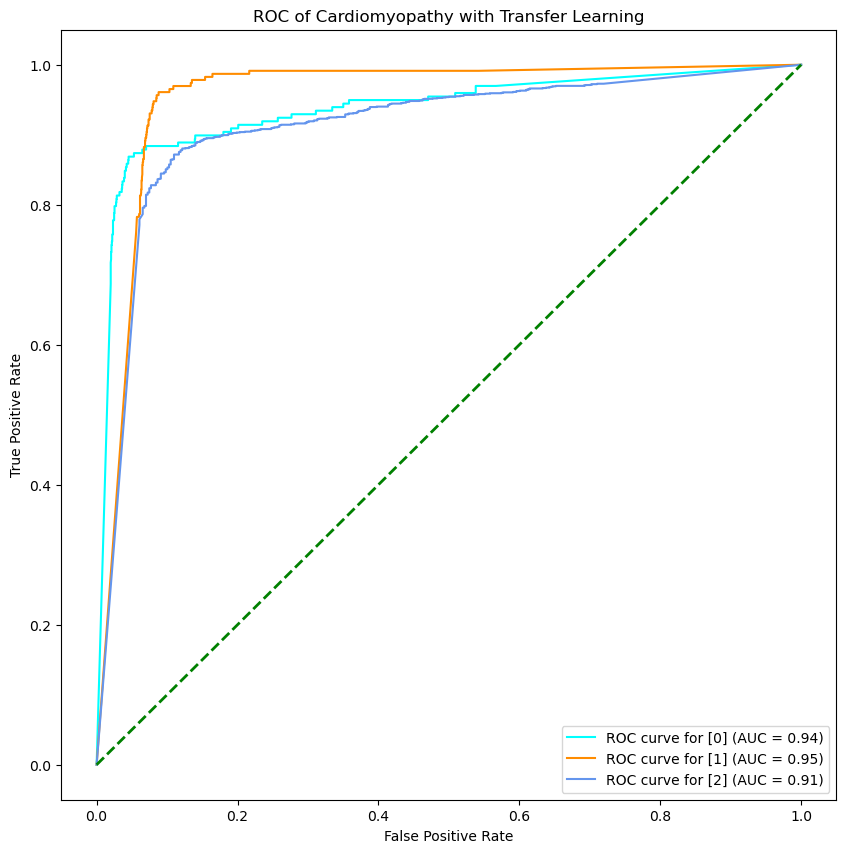

In [11]:
File = 'Test_predicted_probs_'+str(Project)+'.txt'
y_pred = np.loadtxt(File,delimiter=',', dtype=np.float32)
prob_predict3D=y_pred.reshape((-1,3))
pred_0=prob_predict3D
xy_label= y_test
y_test_b = label_binarize(xy_label, classes=[0, 1, 2])
n_classes = y_test_b.shape[1]
n_classes = 3 #for 3 classes
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_b[:, i], pred_0[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fig, ax = plt.subplots(figsize=(10, 10))

colors = ["aqua", "darkorange", "cornflowerblue"]
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        y_test_b[:, class_id],
        pred_0[:, class_id],
        name=f"ROC curve for {[class_id]}",
        color=color,
        ax=ax,
    ) 
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
plt.plot([0, 1], [0, 1], color='green', lw=2, linestyle='--')
plt.title('ROC of '+Title+' with '+mode)
plt.savefig(Title+'_'+mode+'_ROC_comparison.png')

In [12]:
y_true=y_test
y_pred=y_pred
y_pred
#disp=ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred))
#disp.plot()
#plt.show()

array([0.0000000e+00, 0.0000000e+00, 1.0000000e+00, ..., 5.7244487e-13,
       1.0000000e+00, 5.7244487e-13], dtype=float32)

In [13]:
pred_0

array([[0.0000000e+00, 0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 1.0000000e+00],
       ...,
       [5.8702607e-27, 1.0000000e+00, 6.3719418e-18],
       [1.1722442e-23, 1.0000000e+00, 1.1722442e-23],
       [5.7244487e-13, 1.0000000e+00, 5.7244487e-13]], dtype=float32)

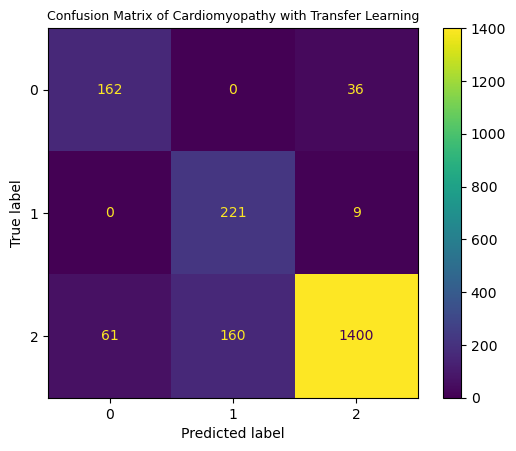

In [14]:
File = 'Test_predicted_labels_'+str(Project)+'.txt'
y_pred = np.loadtxt(File,delimiter=',', dtype=np.float32)
disp=ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred))
disp.plot()
plt.title('Confusion Matrix of '+Title+' with '+mode, fontsize=9)
plt.savefig(Title+'_'+mode+'_Confusion_Matrix.png')

In [19]:
MyModelName='Model_TL.pth'
model.load_state_dict(torch.load(MyModelName))
model.state_dict()['ConvLayer1.0.weight']

tensor([[[[-0.0166,  0.1682, -0.2827],
          [-0.2559, -0.1336,  0.0854],
          [-0.0221,  0.2779, -0.0135]]],


        [[[ 0.0815, -0.1064, -0.0693],
          [-0.3230, -0.2165, -0.1433],
          [ 0.0062,  0.1385,  0.2001]]],


        [[[-0.2181, -0.1306,  0.1272],
          [ 0.2995, -0.0421,  0.2663],
          [-0.0347,  0.0619,  0.3312]]],


        [[[-0.3105, -0.2163, -0.0936],
          [-0.1535,  0.2713, -0.2331],
          [-0.1782, -0.2573, -0.3255]]],


        [[[-0.1965,  0.2837,  0.1462],
          [ 0.1592,  0.0086, -0.1867],
          [ 0.0585, -0.3252, -0.2481]]],


        [[[-0.1569,  0.2208,  0.2099],
          [-0.1360, -0.0141,  0.2073],
          [ 0.3387,  0.1317,  0.0458]]]], device='cuda:0')